In [1]:
%matplotlib inline
import cmlreaders as cml
import pandas_to_pybeh as pb
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
all_repfr_events = cml.CMLReader.load_events(experiments='ltpRepFR', data_type='task_events')

In [67]:
word_evs.drop_duplicates(subset=['subject', 'session', 'item_num'])

,answer_correct,distractor,distractor_answer,eegfile,eegoffset,eogArtifact,experiment,intruded,intrusion,is_repeat,...,mstime,phase,protocol,recalled,rectime,repeats,serialpos,session,subject,type
66,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,593594,0,ltpRepFR,0,-999,False,...,1614014077265,,ltp,True,-999,1,0,0,LTP441,WORD
68,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,598474,0,ltpRepFR,0,-999,False,...,1614014079648,,ltp,True,-999,3,1,0,LTP441,WORD
70,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,603457,0,ltpRepFR,0,-999,False,...,1614014082081,,ltp,True,-999,3,2,0,LTP441,WORD
72,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,608339,0,ltpRepFR,0,-999,False,...,1614014084465,,ltp,True,-999,3,3,0,LTP441,WORD
74,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP441/experiments/ltp...,613458,2,ltpRepFR,0,-999,False,...,1614014086965,,ltp,True,-999,2,4,0,LTP441,WORD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,7463908,2,ltpRepFR,1,-999,False,...,1620399839052,,ltp,True,-999,3,7,9,LTP447,WORD
1736,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,7468858,0,ltpRepFR,1,-999,False,...,1620399841469,,ltp,True,-999,3,8,9,LTP447,WORD
1740,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,7478620,2,ltpRepFR,1,-999,False,...,1620399846236,,ltp,True,-999,2,10,9,LTP447,WORD
1768,False,"[-999, -999, -999]",-999,/protocols/ltp/subjects/LTP447/experiments/ltp...,7548454,0,ltpRepFR,1,-999,False,...,1620399880337,,ltp,True,-999,1,24,9,LTP447,WORD


In [70]:
evs = all_repfr_events[all_repfr_events.list != 0]
word_evs = evs.query('type == "WORD" and repeats != -999')
rec_evs = evs.query('type == "REC_WORD"')
#removing repeat presentations
word_evs = word_evs.drop_duplicates(subset=['subject', 'session', 'item_num'], keep='first')

In [71]:
events = word_evs.append(rec_evs)

In [72]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

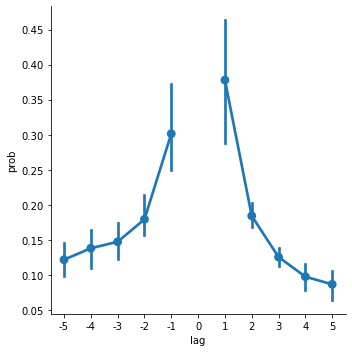

In [73]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )

In [146]:
# replace item nums so they are consistent across subjects
item_col = 'item_name'
item_num_col = 'item_num'
item_num_df = word_evs.drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [97]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [98]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        similarity = keyed_vector.similarity(df[col1].lower(), df[col2].lower())
        return similarity
    except:
        return np.nan

In [99]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=[item_col+'_1', item_col+'_2']).to_frame(index=False)

In [100]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1=item_col+'_1', 
               col2=item_col+'_2', 
               keyed_vector=word2vec_vectors)

In [101]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on=item_col+'_1', right_on=item_col).merge(
    item_num_df, left_on=item_col+'_2', right_on=item_col, suffixes=('_1', '_2'))

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/pandas/core/frame.py:9199: FutureWarning: Passing 'suffixes' which cause duplicate columns {'item_name_1'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


In [102]:
sem_sims = pd.pivot_table(sem_sim_num_df, 
                          index=item_num_col+'_1', 
                          columns=item_num_col+'_2', 
                          values='similarity', dropna=False)

In [103]:
sem_sims

item_num_2,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
item_num_1,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.093802,0.078450,0.057159,0.034051,0.070729,0.073239,0.112888,0.049081,0.047837,...,0.168077,0.124287,0.097129,0.077445,0.109607,0.026574,0.047698,0.037732,0.029283,0.094810
2,0.093802,1.000000,0.281831,0.105119,0.069158,0.124767,0.163965,0.187531,0.257542,0.177455,...,0.149423,0.056477,0.159501,0.169879,0.032616,0.031927,0.105799,0.115933,0.022167,0.051867
3,0.078450,0.281831,1.000000,0.061641,0.181941,0.148749,0.242767,0.275472,0.152656,0.191943,...,0.081318,0.082510,0.144029,0.083378,-0.034839,0.083255,0.072905,0.181092,-0.012596,0.034641
4,0.057159,0.105119,0.061641,1.000000,0.050493,0.226413,0.096811,0.126179,0.138249,0.166358,...,0.074008,0.115402,0.075006,0.063898,0.172232,0.190273,0.062068,0.097635,0.094713,0.153709
5,0.034051,0.069158,0.181941,0.050493,1.000000,0.013218,0.151876,0.108896,0.148753,0.142940,...,0.162555,0.050095,0.154301,0.198449,0.170816,-0.083961,0.151912,0.245477,0.112816,-0.055154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0.026574,0.031927,0.083255,0.190273,-0.083961,0.113055,0.054186,0.015970,0.073257,0.082843,...,0.038376,0.148560,0.061909,0.059832,0.091957,1.000000,0.059808,0.052544,0.147451,0.424793
309,0.047698,0.105799,0.072905,0.062068,0.151912,0.027036,-0.017690,0.098232,0.118364,0.150116,...,0.219115,0.152991,0.138390,0.029983,0.279959,0.059808,1.000000,0.037833,0.040204,0.106878
310,0.037732,0.115933,0.181092,0.097635,0.245477,0.043106,0.113970,0.029371,0.029460,0.058402,...,0.038389,0.032818,0.035763,0.123888,-0.000956,0.052544,0.037833,1.000000,0.181162,-0.036749


In [149]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column=item_num_col+'_new', sem_sims=sem_sims).reset_index()

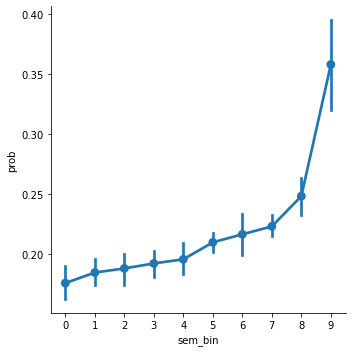

In [150]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp
           )

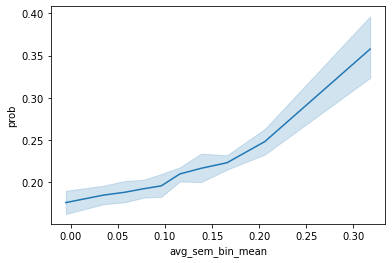

In [151]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp)